In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import pickle
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
import pydicom as dcm
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder
from torchvision.transforms import Compose, ToTensor, Normalize, RandomAffine, RandomResizedCrop
import pneumonia.preprocess as preproc
from pneumonia.evaluate import evaluate_classifier, show_random_images
from pneumonia.classifier import PneumoniaClassifier, train_pneumonia_classifier

# Take a look at the x-ray images

Here we use the [RSNA Pneumonia Detection Challange](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data) dataset from kaggle.

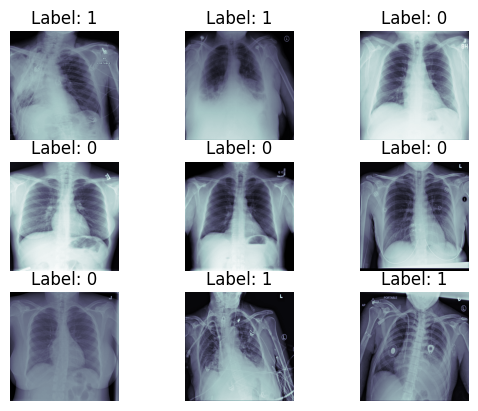

In [3]:
raw_dir = 'data/stage_2_train_images'
label_path = 'data/stage_2_train_labels.csv'

num_images = 9
labels = pd.read_csv(label_path)
dicom_files = [file for file in os.listdir(raw_dir) if file.endswith('.dcm')]

# Plot the pixel array of the first 9 DICOM images
for i in range(num_images):
    file_path = os.path.join(raw_dir, dicom_files[i])
    patient_id = os.path.splitext(dicom_files[i])[0]
    label = labels[labels['patientId'] == patient_id]['Target'].iloc[0]
    ds = dcm.dcmread(file_path)
    pixel_array = ds.pixel_array
    plt.subplot(3, 3, i+1)
    plt.title(f'Label: {label}')
    plt.imshow(pixel_array, cmap='bone')
    plt.axis('off')

plt.show()


# Parameters

In [4]:
shape = (224, 224)
raw_dir = raw_dir
label_path = label_path
preproc_dir = 'preprocessed'
batch_size = 64
num_workers = 4

# Preprocessing

In [5]:
if not os.path.exists(preproc_dir):
    preproc.preprocess(raw_dir, label_path, preproc_dir, shape)
    
standard_params = preproc.compute_standard_params(preproc_dir, shape)
current_date = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
params_path = f'../parameters/standard_params_{current_date}.pkl'
with open(params_path, 'wb') as file:
    pickle.dump(standard_params, file)



Processing label: 1


  0%|          | 0/4825 [00:00<?, ?it/s]

Processing label: 0


  0%|          | 0/16491 [00:00<?, ?it/s]

# Construct data loader

In [6]:
def load_img(file_name):
    return np.load(file_name).astype(np.float32)

In [7]:
train_transforms = Compose([
    ToTensor(),
    Normalize(*standard_params),
    RandomAffine(degrees=5, translate=(0, 0.05), scale=(0.9, 1.1)),
    RandomResizedCrop(224, scale=(0.35, 1.))
])
val_transforms = Compose([ToTensor(), Normalize(*standard_params)])

In [8]:
train_data = DatasetFolder(os.path.join(preproc_dir, 'train'), 
loader=load_img, extensions='.npy', transform=train_transforms)
val_data = DatasetFolder(os.path.join(preproc_dir, 'val'), loader=load_img, extensions='.npy', transform=val_transforms)

In [9]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)


In [10]:
np.unique(train_data.targets, return_counts=True), np.unique(val_data.targets, return_counts=True)

((array([0, 1]), array([16491,  4825])), (array([0, 1]), array([4181, 1187])))

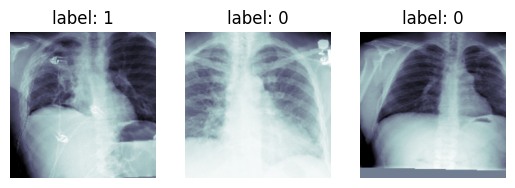

In [11]:
for batch in train_loader:
    for i in range(3):
        rand_idx = np.random.randint(batch[0].shape[0])
        plt.subplot(1, 3, i+1)
        plt.imshow(batch[0][rand_idx, 0, :, :], cmap='bone')
        plt.title(f'label: {batch[1][rand_idx]}')
        plt.axis('off')
    break

# Create and train model

In [12]:
model = train_pneumonia_classifier(train_loader, val_loader, log_dir='logs', checkpoint_dir='checkpoints')

/home/borbalita/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/borbalita/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024-02-11 19:43:54.410814: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/borbalita/miniconda3/envs/cv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


# Save model

In [16]:
model_dir = Path('../parameters')
current_date = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
file_name = f'resnet_{current_date}.pth'

os.makedirs(model_dir, exist_ok=True)
torch.save(model.state_dict(), model_dir / file_name)

# Load model

In [18]:
model_path = '../parameters/resnet_20240211235509.pth'
model = PneumoniaClassifier()
model.load_state_dict(torch.load(model_path))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

PneumoniaClassifier(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

# Evaluation

Computing training predictions


100%|██████████| 334/334 [11:14<00:00,  2.02s/it]


Computing validation predictions


100%|██████████| 84/84 [02:39<00:00,  1.89s/it]


Running evaluation with threshold: 0.25
              train       val
acc        0.679818  0.669151
precision  0.396652  0.384555
recall      0.79544  0.826453


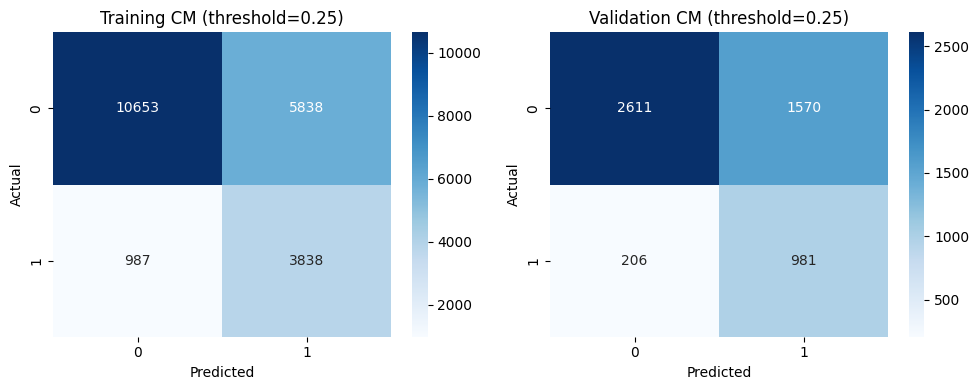

Running evaluation with threshold: 0.50
              train       val
acc        0.790298  0.785022
precision  0.543051  0.515464
recall     0.464041  0.463353


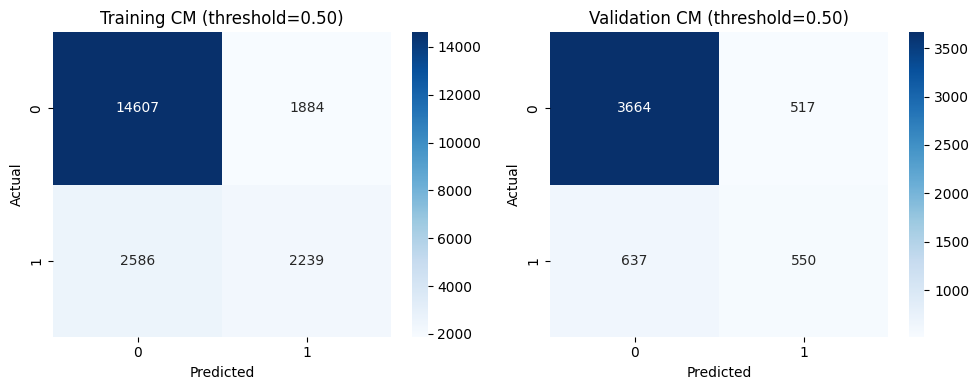

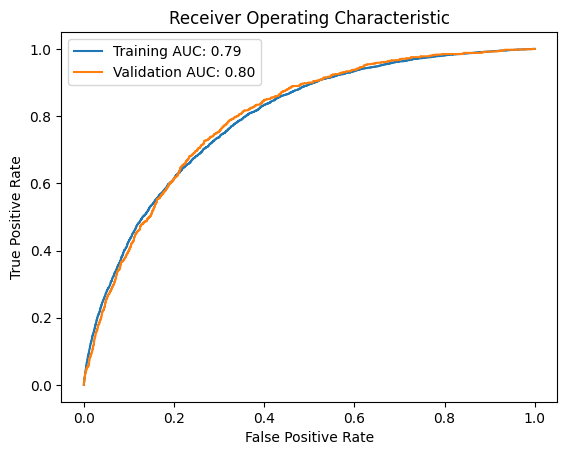

In [21]:
train_preds, train_labels, val_preds, val_labels = evaluate_classifier(model, train_loader, val_loader)

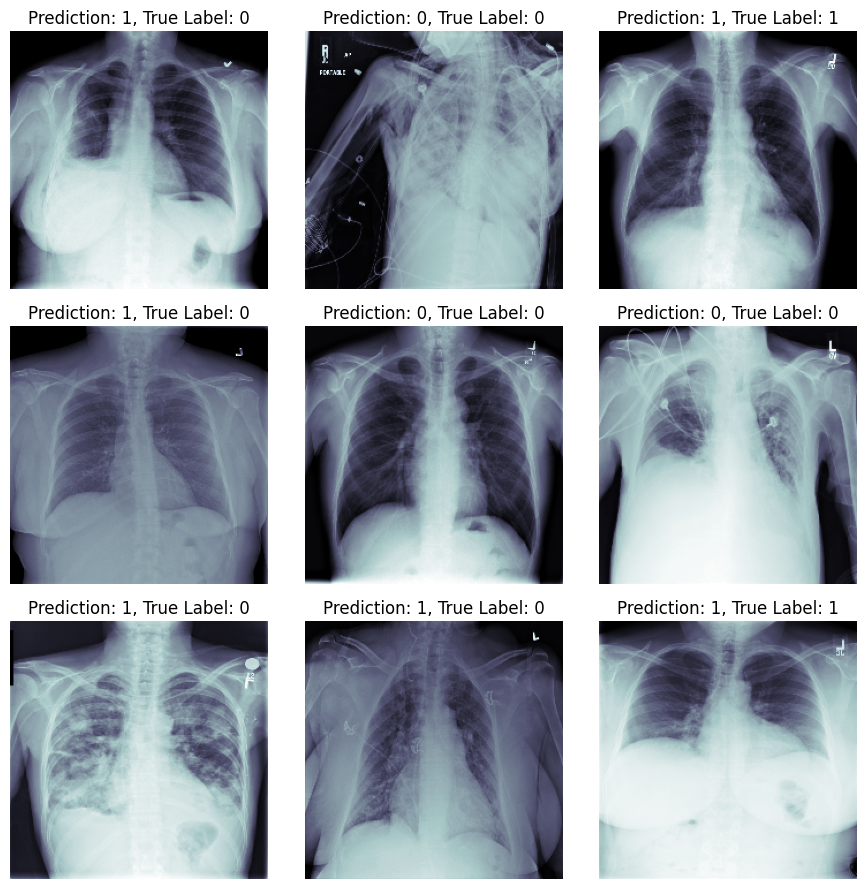

In [24]:
show_random_images(val_data, val_preds, val_labels)